In [25]:
import os
import pandas as pd
import numpy as np
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


notebook_dir = os.path.dirname(os.path.abspath('__file__'))
csv_path = os.path.join(notebook_dir, '..', 'clean_data', 'main_df_clean.csv')

In [26]:
merged_df = pd.read_csv(csv_path)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%m/%Y')
merged_df = merged_df.sort_values('Date')
merged_df = merged_df.set_index('Date')
merged_df

,Coffee,close,vnd Exchange Rate,hnl Exchange Rate,cop Exchange Rate,brl Exchange Rate,Negative_News_Ratio,idr Exchange Rate,Sugar,Milk,...,Honduras_et0_fao_evapotranspiration_hon,Honduras_temperature_2m_mean_hon,Colombia_et0_fao_evapotranspiration_col,Vietnam_temperature_2m_mean_vn,Vietnam_et0_fao_evapotranspiration_vn,Vietnam_wind_speed_10m_max_vn,Indonesia_temperature_2m_mean_in,Indonesia_et0_fao_evapotranspiration_in,Indonesia_precipitation_sum_in,Honduras_precipitation_sum_hon
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0.758300,79.99,5479.329529,2.0000,440.08,0.000006,0.158372,1804.850000,0.142000,0.071100,...,3.320075,22.378282,2.884960,21.289052,4.109480,21.893360,25.252577,3.412106,6.867742,1.935484
1990-02-01,0.840100,93.79,5479.329529,2.0000,451.72,0.000010,0.159264,1809.870000,0.146500,0.074176,...,3.872699,23.166586,2.824487,22.938695,4.699384,19.576097,25.438890,3.518966,8.982143,1.210714
1990-03-01,0.939600,92.14,5479.329529,4.0000,463.40,0.000016,0.160195,1820.350000,0.153100,0.077182,...,4.214509,23.867664,3.066009,24.077493,5.127649,18.735996,25.706005,3.814265,9.561290,2.361290
1990-04-01,0.937300,93.73,5479.329529,4.0000,474.62,0.000021,0.161169,1826.050000,0.152400,0.077874,...,4.871768,26.082444,2.559262,25.045932,4.603029,16.039177,26.231305,3.766648,6.286667,3.386667
1990-05-01,0.920200,94.05,5563.430866,4.2000,485.99,0.000023,0.162188,1831.400000,0.146200,0.087742,...,4.842873,25.555970,2.534520,24.485961,4.032747,13.179221,26.307215,3.583512,5.732258,6.467742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,2.570987,229.20,24251.560000,24.8582,4036.80,5.541448,0.065923,16261.652826,0.193517,0.242129,...,4.118606,24.569386,3.700725,22.884045,3.154708,19.842825,26.897843,4.220664,3.645161,8.112903
2024-08-01,2.614377,244.05,24245.850000,24.8826,4062.98,5.552014,0.065906,15793.181818,0.184195,0.244700,...,4.518683,24.659843,3.831915,24.035121,4.171292,14.406041,28.485544,4.954863,1.296774,8.254839
2024-09-01,2.787605,270.25,24163.540000,24.8381,4191.86,5.540967,0.065879,15341.250000,0.206248,0.251466,...,4.216293,24.876693,4.067470,23.041320,3.153404,17.546168,27.723999,4.434608,6.356667,9.396667


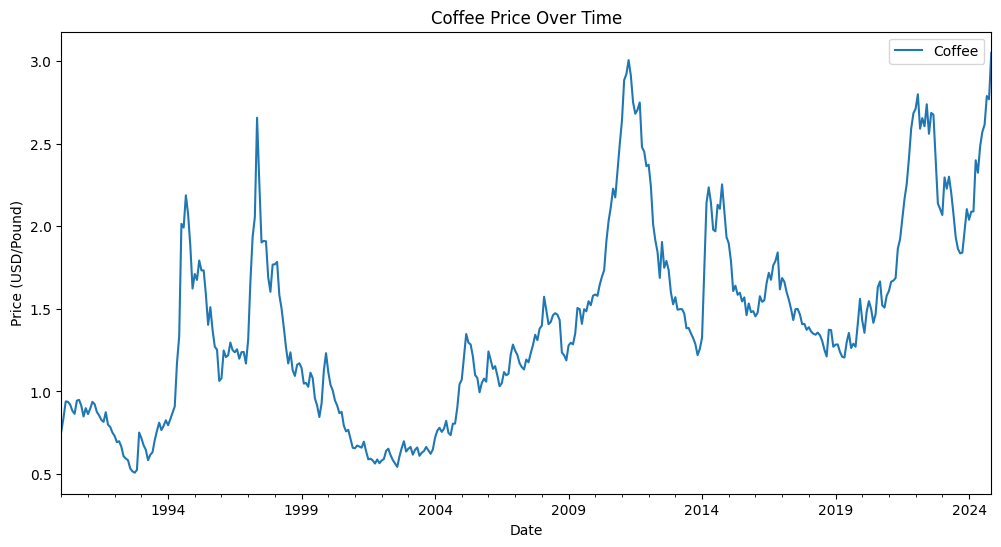

In [27]:
merged_df.plot(y='Coffee', title='Coffee Price Over Time', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.show()

In [28]:
y_diff = merged_df['Coffee'].diff().dropna()
x_diff = merged_df.drop(columns=['Coffee']).diff().dropna()

X_diff = x_diff.loc[y_diff.index]

In [29]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y_diff, X_diff, test_size=0.2)

In [30]:
forecaster = make_reduction(
    RandomForestRegressor(random_state=42),
    strategy='recursive',
    window_length=12
)

In [31]:
forecaster.fit(y_train, X=X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(random_state=42),
                                     window_length=12)

In [32]:
fh = np.arange(1, len(y_test) + 1)
y_pred_diff = forecaster.predict(fh, X=X_test)

last_train_level = merged_df['Coffee'].loc[y_train.index[-1]]
y_pred_level = y_pred_diff.cumsum() + last_train_level

y_test_level = y_test.cumsum() + last_train_level


mse_level = mean_squared_error(y_test_level, y_pred_level)
mae_level = mean_absolute_error(y_test_level, y_pred_level)
print('Mean Squared Error on Level Predictions:', mse_level)
print('Mean Absolute Error on Level Predictions:', mae_level)

Mean Squared Error on Level Predictions: 0.05679018674533644
Mean Absolute Error on Level Predictions: 0.19479019783958335


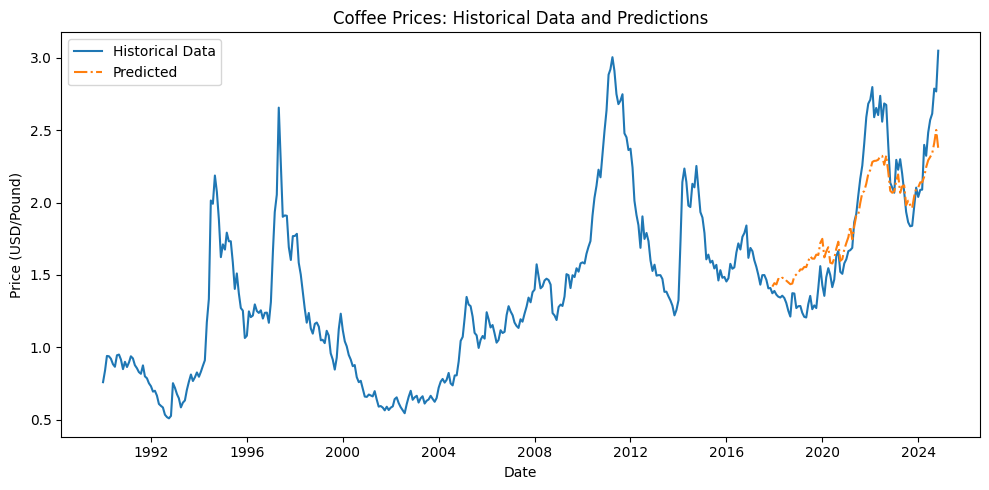

In [33]:
plt.figure(figsize=(10, 5))

plt.plot(merged_df.index, merged_df['Coffee'], label='Historical Data')

test_dates = merged_df.index[-len(y_test):]
plt.plot(test_dates, y_pred_level, label='Predicted', linestyle='-.')

plt.title('Coffee Prices: Historical Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD/Pound)')
plt.legend()
plt.tight_layout()
plt.show()